In [1]:
#| default_exp setup

In [2]:
#| hide
from nbdev.showdoc import *
import nbdev 
from nbdev import nbdev_export

## imports

In [4]:
#| export 
import warnings
warnings.filterwarnings("ignore")

import os
import json
import salem
import skimage.draw as skdraw

import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon

import numpy as np
import pandas as pd

import scipy
from scipy.stats import invgauss

import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib as mpl
import hvplot.pandas
import hvplot.xarray

import geoviews as gv
import geoviews.feature as gf
#import ipywidgets as ipw
import panel as pn

import s3fs
# to get and use geojson datacube catalog
import json
import logging
# for timing data access
import time
import xrspatial
import numpy as np
import pyproj
import s3fs as s3
# for datacube xarray/zarr access
import xarray as xr
import rioxarray as rio
from pyproj import Transformer
# for plotting time series
from shapely import geometry
from tqdm import tqdm
import re
import ipyleaflet as ipyl
import ipywidgets as ipyw
import json
import pandas as pd
from ipywidgets import HTML


logging.basicConfig(level=logging.ERROR)
# import pandas as pd

In [5]:
#| export
from itslivetools import datacube_tools

In [6]:
#| export 
from oggm import cfg, utils, graphics
import skimage.draw as skdraw

from oggm import workflow, tasks
from oggm import DEFAULT_BASE_URL
from oggm.shop import its_live, rgitopo, bedtopo

## Defining classes

In [1]:
#| export
def point_to_gdf(point_ls):
    '''
    creates a geodataframe from a given point

    input: list of [x,y] coords
    output: geopandas gdf of point, in epsg:4326
    '''
        
    d = {'x': point_ls[0],
         'y': point_ls[1]}
    df = pd.DataFrame(d, index=[0])
    gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y, crs='EPSG:4326'))
    return gdf

In [2]:
#| export
class Glacier():
    '''class to hold all data associated with individual glacier
    inputs: name (str), rgi_id (str), working_dir_path (str, where oggm data should be written)
    url (str, url to oggm prepro data), centerline path (str, path to locally stored 
    centerline data (**wanted to have this not rely on local data but haven't gotten that working yet**)
    
    '''
    def __init__(self, name, rgi_id, working_dir_path, url, centerline_path, utm_crs):

        self.name = name
        self.rgi_id = rgi_id
        self.data_url = url
        self.working_dir_path = working_dir_path
        self.centerline_path = centerline_path
        self.g = self._oggm_setup()
        self.utm_crs = utm_crs
        self.centerlines = self._add_centerline()
        self.centerline_main = self.centerlines.loc[self.centerlines['MAIN'] == 1]
        prod = self._add_oggm_gridded_data()
        self.gridded_data = prod[0]
        self.outline = prod[1]
        self.utm_gridded_data = self._reproject_vars()
        self.centerline_gridded_data = self._oggm_gridded_clip2centerline()
        #self.image_pair_centerline = self.add_image_pair_timeseries()
        
    def _oggm_setup(self, prepro_level = 2):
        '''method to initialize oggm data that will be used for itslive image pair data 
        preprocessing, and overall data object (thickness, itslive_mosaic, dem, outline) 
        '''
        cfg.initialize(logging_level='WARNING')
        cfg.PARAMS['use_multiprocessing'] = True
        cfg.PATHS['working_dir'] = utils.mkdir(path=self.working_dir_path, reset=False)

        gdirs = workflow.init_glacier_directories(
            self.rgi_id, prepro_base_url = self.data_url,
            from_prepro_level=prepro_level, prepro_border=80)
        list_talks = [
            tasks.glacier_masks,
            its_live.velocity_to_gdir,
            bedtopo.add_consensus_thickness,
        ]
        for task in list_talks:
            workflow.execute_entity_task(task, gdirs)
            
        return gdirs

    def _add_centerline(self):
        '''method to add centerline (from local file) as attr to glacier object
        '''
        cl = gpd.read_file(self.centerline_path)
        cl = cl.loc[cl['RGIID'] == self.rgi_id]
        return cl 

    def _add_oggm_gridded_data(self):
        '''method to add oggm gridded data + outline to glacier object 
        '''
        g = self.g[0]
        with xr.open_dataset(g.get_filepath('gridded_data')) as ds:
            gridded_data = ds.load()
            gridded_data.rio.write_crs(gridded_data.attrs['pyproj_srs'], inplace=True)
           
        outline = g.read_shapefile('outlines')
        
        for var in gridded_data.data_vars:
            gridded_data[var].rio.write_nodata(-9999., inplace=True)
            gridded_data[var].rio.reproject(self.utm_crs, inplace=True)
        return gridded_data, outline
        
    def _reproject_vars(self):
        da_ls = []
        for var in self.gridded_data.data_vars:
            da_ls.append(self.gridded_data[var].rio.reproject(self.utm_crs))
        ds = xr.merge(da_ls)
        return ds
        
    def _oggm_gridded_clip2centerline(self):

        vec = self.centerline_main.to_crs(self.utm_crs)
        clip = self.utm_gridded_data.rio.clip(vec.geometry, vec.crs)
        clip.itslive_v.rio.write_nodata(-9999., inplace=True)
        nodata = clip.itslive_v.rio.nodata
        clip = clip.where(clip != nodata)
        clip.itslive_v.rio.write_nodata(nodata, encoded=True, inplace=True)
        return clip
        
    
        
def remove_empty_timesteps(ds):
    ds['step_count'] = (('mid_date'), range(len(ds['mid_date'])))
    ds = ds.swap_dims({'mid_date':'step_count'})
    time_step_keep = list(ds.v.dropna(how='all',dim='step_count').step_count.data)
    ds_subset = ds.where(ds.step_count.isin(time_step_keep), drop=True)
    ds_subset = ds_subset.swap_dims({'step_count':'mid_date'})
    
    return ds_subset


In [3]:
#| export 
class Point():

    def __init__(self, name, label, rgi_id, glacier_obj, point_coords_latlon, utm_crs, var_ls):

        self.name = name
        self.label = label
        self.rgi_id = rgi_id
        self.utm_crs = utm_crs
        self.glacier_gridded_data = glacier_obj.utm_gridded_data
        self.glacier_centerline = glacier_obj.centerline_main
        self.point_latlon = point_coords_latlon
        self.point_gdf = self.point_to_gdf()
        self.point_v = self._point_v_mosaic().itslive_v
        self.datacube_point = self._add_image_pair_point(var_ls)
        self.datacube_sub = self._add_image_pair_subcube(var_ls)
        self.padded_centerline_subcube = self._extract_subcube_along_padded_centerline()
        self.TRIM_padded_centerline_subcube = self._subset_ds_by_sensor_baseline('cl')
        self.TRIM_subcube = self._subset_ds_by_sensor_baseline('dc_full')
        self.cube_around_point = self._extract_3x3_cube_around_point()
        self.TRIM_cube_around_point = self._subset_ds_by_sensor_baseline('dc_cube')

    def point_to_gdf(self):
        
        d = {'x': self.point_latlon[0],
             'y':self.point_latlon[1]}
        df = pd.DataFrame(d, index=[0])
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y, crs='EPSG:4326'))
        return gdf

    def _point_v_mosaic(self):

        point_utm = self.point_gdf.to_crs(self.utm_crs)
        
        ds_clip = self.glacier_gridded_data.rio.clip(point_utm.geometry, point_utm.crs)
        return ds_clip
            
    def _add_image_pair_point(self, var_ls):

        dc = datacube_tools.DATACUBETOOLS()
        var_ls = var_ls 
        dc_point_full = dc.get_timeseries_at_point(self.point_latlon, point_epsg_str = '4326', variables = var_ls)
        dc_point = dc_point_full[1]
        crs = f"EPSG:{dc_point.mapping.attrs['spatial_epsg']}"
        dc_point = dc_point.rio.write_crs(crs)
        #dc_point = dc_point.rio.write_nodata(np.nan)
        dc_point = dc_point.dropna(how='any', dim='mid_date')

    
        dc_point['acquisition_date_img1'] = (('mid_date'), pd.to_datetime(dc_point.acquisition_date_img1))
        dc_point['acquisition_date_img2'] = (('mid_date'), pd.to_datetime(dc_point.acquisition_date_img2))
    
        dc_point['img_separation'] = -1*((dc_point.acquisition_date_img1 - dc_point.acquisition_date_img2).astype('timedelta64[D]') / np.timedelta64(1,'D'))

        return dc_point

    def remove_empty_timesteps(ds):
        ds['step_count'] = (('mid_date'), range(len(ds['mid_date'])))
        ds = ds.swap_dims({'mid_date':'step_count'})
        time_step_keep = list(ds.v.dropna(how='all',dim='step_count').step_count.data)
        ds_subset = ds.where(ds.step_count.isin(time_step_keep), drop=True)
        ds_subset = ds_subset.swap_dims({'step_count':'mid_date'})

        return ds_subset
        
    def _add_image_pair_subcube(self, var_ls):

        dc = datacube_tools.DATACUBETOOLS()
        var_ls = var_ls
        dc_full_sub = dc.get_subcube_around_point(self.point_latlon, point_epsg_str = '4326', variables=var_ls)
        crs = f"EPSG:{dc_full_sub[0].mapping.attrs['spatial_epsg']}"
        dc_sub = dc_full_sub[1]
        dc_sub = dc_sub.rio.write_crs(crs)
        #dc_sub = dc_sub.rio.write_nodata(np.nan)
        dc_sub = dc_sub.dropna(how='all', dim='mid_date')
        dc_sub['acquisition_date_img1'] = (('mid_date'), pd.to_datetime(dc_sub.acquisition_date_img1))
        dc_sub['acquisition_date_img2'] = (('mid_date'), pd.to_datetime(dc_sub.acquisition_date_img2))
    
        dc_sub['img_separation'] = -1*((dc_sub.acquisition_date_img1 - dc_sub.acquisition_date_img2).astype('timedelta64[D]') / np.timedelta64(1,'D'))

        dc_sub = remove_empty_timesteps(dc_sub)
        
        return dc_sub

    def _extract_subcube_along_padded_centerline(self, pad=200):
        
        cl = self.glacier_centerline.to_crs(self.utm_crs)
        line = shapely.geometry.LineString(cl.get_coordinates().loc[:,['x','y']].values)
        PAD = pad #meters
        line_buf = gpd.GeoSeries([line], crs=self.utm_crs).buffer(PAD, cap_style=2)
        padded_cl_gdf = gpd.GeoDataFrame({'id':self.label,
                                  'padding':120}, index=[0], geometry=line_buf)
        glacier_subcube_cl = self.datacube_sub.rio.clip(padded_cl_gdf.geometry, padded_cl_gdf.crs)
        return glacier_subcube_cl

    def _subset_ds_by_sensor_baseline(self, format):
        
        min_tb_df = calc_min_tbaseline(self)
        
        #split ds by sensor (sensor options are hardcoded, will need to update when rest of landsat added 
        if format == 'cl': 
            l8 = self.padded_centerline_subcube.where(self.padded_centerline_subcube.satellite_img1 == '8.0',drop=True)
            l9 = self.padded_centerline_subcube.where(self.padded_centerline_subcube.satellite_img1 == '9.0',drop=True)
            s1 = self.padded_centerline_subcube.where(self.padded_centerline_subcube.satellite_img1.isin(['1A','1B']),drop=True)
            s2 = self.padded_centerline_subcube.where(self.padded_centerline_subcube.satellite_img1.isin(['2A','2B']),drop=True)
        elif format == 'dc_full':
            l8 = self.datacube_sub.where(self.datacube_sub.satellite_img1 == '8.0',drop=True)
            l9 = self.datacube_sub.where(self.datacube_sub.satellite_img1 == '9.0',drop=True)
            s1 = self.datacube_sub.where(self.datacube_sub.satellite_img1.isin(['1A','1B']),drop=True)
            s2 = self.datacube_sub.where(self.datacube_sub.satellite_img1.isin(['2A','2B']),drop=True)
            
        elif format == 'dc_cube':
            l8 = self.cube_around_point.where(self.datacube_sub.satellite_img1 == '8.0',drop=True)
            l9 = self.cube_around_point.where(self.datacube_sub.satellite_img1 == '9.0',drop=True)
            s1 = self.cube_around_point.where(self.datacube_sub.satellite_img1.isin(['1A','1B']),drop=True)
            s2 = self.cube_around_point.where(self.datacube_sub.satellite_img1.isin(['2A','2B']),drop=True)
    
        l8_sub = l8.where(l8.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L8']['min_tb (days)']), drop=True)
        l9_sub = l9.where(l9.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L9']['min_tb (days)']), drop=True)
        s1_sub = s1.where(s1.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'S1']['min_tb (days)']), drop=True)
        s2_sub = s2.where(s2.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'S2']['min_tb (days)']), drop=True)
        ds_ls = [l8_sub, l9_sub, s1_sub, s2_sub]
        concat_ls = []
        for ds in range(len(ds_ls)):
            if len(ds_ls[ds].mid_date) > 0:
                concat_ls.append(ds_ls[ds])
        combine = xr.concat(concat_ls, dim='mid_date')
        combine = combine.sortby(combine.mid_date)
        return combine
        
    def _extract_3x3_cube_around_point(self):
    
        padded_point = gpd.GeoDataFrame({'id':self.label}, 
                                index=[0],
                                geometry = self.point_gdf.to_crs('EPSG:32643').buffer(distance=200))
        dc = self.datacube_sub.rio.clip(padded_point.geometry, padded_point.crs)

        return dc
                         
def calc_min_tbaseline(Point):
    med_v = Point.point_v.data[0][0]
    gsd_s2, gsd_l8, gsd_s1, gsd_l9 = 10,15, 10, 15
    name_ls = ['S2','L8','S1', 'L9']
    gsd_ls = [gsd_s2, gsd_l8, gsd_s1, gsd_l9]
    sensor_str_ls = [['2A','2B'], '8.0',['1A','1B'],'9.0']
    min_tb_ls = []
    for element in range(len(gsd_ls)):
        min_tb = ((gsd_ls[element]*2)/med_v)*365
        min_tb_ls.append(min_tb)
        #print(min_tb, ' days')

    min_tb_dict= {'sensor':name_ls, 
                  'gsd': gsd_ls, 
                  'min_tb (days)': min_tb_ls,
                 'sensor_str':sensor_str_ls}
    df = pd.DataFrame(min_tb_dict)
    return df

## Examples - baltoro

### Inputs

In [8]:
#paths for centerline data
data_gen_path = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/'
centerline_dir = 'oggm_flowlines/'
centerline_14_path = os.path.join(data_gen_path, centerline_dir, 'rgi_14/centerlines_smoothed_14.shp')
#working dir path for oggm 
wd_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023_fall/oggm_scratch'
l12_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/centerlines/'
#ind glacier inputs 
rgi_id = 'RGI60-14.06794'
point = [76.3797, 35.7376]
label = 'mid-glacier'

### Glacier

In [7]:
baltoro = Glacier('baltoro', rgi_id, wd_path, l12_url, centerline_14_path, 'EPSG:32643')

2023-10-19 12:15:22: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-10-19 12:15:22: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-10-19 12:15:22: oggm.cfg: Multiprocessing: using slurm allocated processors (N=4)
2023-10-19 12:15:27: oggm.cfg: Multiprocessing switched ON after user settings.
2023-10-19 12:15:28: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2023-10-19 12:15:28: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-10-19 12:15:31: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2023-10-19 12:15:35: oggm.workflow: Execute entity tasks [velocity_to_gdir] on 1 glaciers
2023-10-19 12:15:37: oggm.workflow: Execute entity tasks [add_consensus_thickness] on 1 glaciers


#### Take a look at itslive mosaic along flowline:

In [8]:
#| hide
baltoro.outline.to_crs(baltoro.utm_crs).hvplot(color='None')*baltoro.centerline_gridded_data.itslive_v.hvplot(cmap='viridis')

:Overlay
   .Polygons.I :Polygons   [x,y]
   .Image.I    :Image   [x,y]   (itslive_v)

#### Baltoro centerline DEM (L) and itslive mosaic (R)

In [9]:
#| hide
baltoro.centerline_gridded_data.topo.hvplot(cmap='viridis') + baltoro.centerline_gridded_data.itslive_v.hvplot(cmap='viridis')

:Layout
   .Image.I  :Image   [x,y]   (topo)
   .Image.II :Image   [x,y]   (itslive_v)

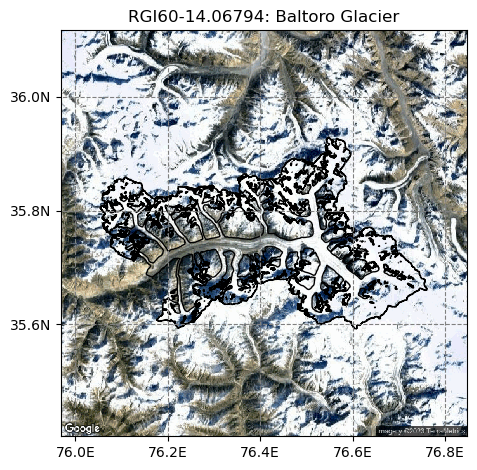

In [10]:
#| hide
graphics.plot_googlemap(baltoro.g)

In [11]:
#| hide
topo_ext = baltoro.gridded_data.topo.where(baltoro.gridded_data.glacier_mask==1)
terminus = topo_ext.where(topo_ext==topo_ext.min(),drop=True)

In [20]:
terminus

<xarray.DataArray 'topo' (y: 1, x: 1)>
array([[3397.]], dtype=float32)
Coordinates:
  * x            (x) float32 -2.264e+04
  * y            (y) float32 3.95e+06
    spatial_ref  int64 0
Attributes:
    units:       m
    long_name:   DEM topography
    _FillValue:  -9999.0

### Point

In [36]:
var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']


baltoro_mid_point = Point('Baltoro','baltoro mid point','RGI60-14.06794', baltoro, point, 'EPSG:32643', var_ls)

original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
original xy [76.3797, 35.7376] 4326 maps to datacube (624763.5766152533, 3955722.574253059) EPSG:32643
subset and load at  21.05 seconds


In [37]:
baltoro_mid_point.

In [46]:
baltoro_mid_point.TRIM_padded_centerline_subcube.v.mean(dim='mid_date').hvplot()*baltoro_mid_point.cube_around_point.mean(dim='mid_date').v.hvplot(cmap='plasma')

:Overlay
   .Image.I  :Image   [x,y]   (v)
   .Image.II :Image   [x,y]   (v)

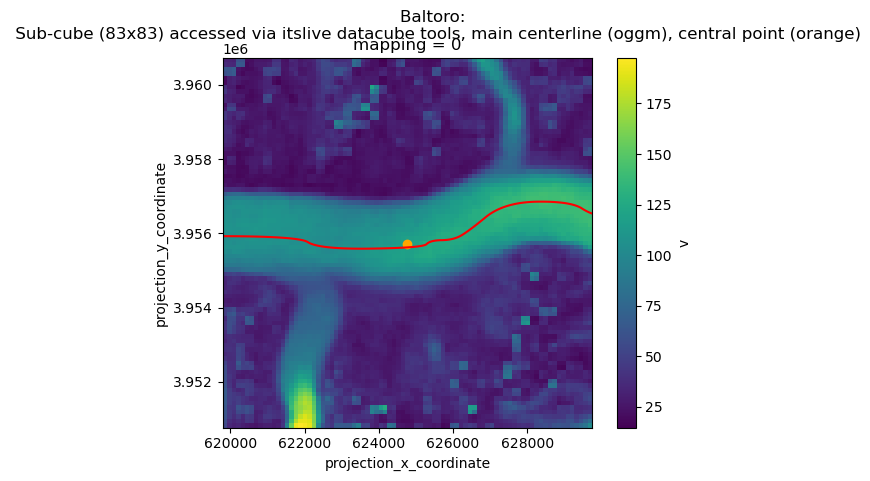

In [51]:
fig, ax = plt.subplots()
baltoro_mid_point.datacube_sub.v.mean(dim='mid_date').plot(ax=ax)
baltoro.centerline_main.to_crs(baltoro.utm_crs).plot(ax=ax, color='red')
baltoro_mid_point.point_gdf.to_crs(baltoro_mid_point.utm_crs).plot(ax=ax, color='orange')
fig.suptitle('Baltoro: \n Sub-cube (83x83) accessed via itslive datacube tools, main centerline (oggm), central point (orange)');

# Comparing full time series v. trimmed time series (temporal baseline threshold)

## full dataset (spatial median of 9 pixels surrounding point on centerline) (Left) -- Baltoro outline and location of points (Right)

In [12]:
baltoro_mid_point.cube_around_point.v.median(dim=['x','y']).hvplot.scatter(x='mid_date') + (baltoro.outline.to_crs('EPSG:32643').hvplot(color='None') * baltoro_mid_point.cube_around_point.v.mean(dim='mid_date').hvplot(cmap='reds'))

NameError: name 'baltoro_mid_point' is not defined

### Left: trimmed time series (median of 3x3 cube along centerline), Right: baltoro outline, cube

In [71]:
baltoro_mid_point.TRIM_cube_around_point.v.median(dim=['x','y']).hvplot.scatter(x='mid_date') + (baltoro.outline.to_crs('EPSG:32643').hvplot(color='None') *baltoro_mid_point.TRIM_cube_around_point.v.mean(dim='mid_date').hvplot(cmap='reds'))

:Layout
   .Scatter.I :Scatter   [mid_date]   (v)
   .Overlay.I :Overlay
      .Polygons.I :Polygons   [x,y]
      .Image.I    :Image   [x,y]   (v)

## Next steps

1. horizontal span time series plots to show data excluded by the temporal baseline threshold filter
2. finalize thresholding approach
    ideally, data that doesn't pass the filter isn't entirely excluded (maybe there is a 2-tier threshold where below 1 (loqwe) temp baseline data is excluded, and an intermediate threshold below which credibility is negatively weighted
3. regression on remaining obs that pass thresholding to arrive at descriptive function, credibility intervals

In [72]:
!pwd

/uufs/chpc.utah.edu/common/home/u1269862/2023_fall/itslivetools/nbs


### Test - GP implementation on point/cube

In [15]:
baltoro_mid_point_cube_df = baltoro_mid_point.cube_around_point[['v','img_separation']].to_dataframe()

In [17]:
baltoro_mid_point_cube_df = baltoro_mid_point_cube_df.reset_index()

In [26]:
#df['mid_date'] = pd.to_datetime(df['mid_date'])
#df = df.sort_values(by='mid_date')
#df['days_since_middate0'] = [i.days for i in df['mid_date'] - df['mid_date'].iloc[0]]

baltoro_mid_point_cube_df = baltoro_mid_point_cube_df.sort_values(by='mid_date')
baltoro_mid_point_cube_df['days_since_middate0'] = [i.days for i in baltoro_mid_point_cube_df['mid_date'] - baltoro_mid_point_cube_df['mid_date'].iloc[0]]

In [88]:
def select_point_filter_baselines(df, cutoff1, cutoff2, cutoff3):

    #df_pt = df.loc[df['real_label'] == point]
    df_pt = df
    df_pt = df_pt.dropna(subset=['v'])

    df_short = df_pt.loc[(df_pt['img_separation'] >= cutoff1) & (df_pt['img_separation'] < cutoff2)]
    df_med = df_pt.loc[(df_pt['img_separation'] >= cutoff2) & (df_pt['img_separation'] < cutoff3)]
    df_long = df_pt.loc[(df_pt['img_separation'] >= cutoff3) & (df_pt['img_separation'] < cutuff4)]
    df_extralong = df_pt.loc[df_pt['img_separation'] >= cutoff4]                                                        
                                                    

    return (df_pt, df_short, df_med, df_long, df_extralong)

In [38]:
df_point, df0, df1, df2 = select_point_filter_baselines(baltoro_mid_point_cube_df, 60, 120, 180)

In [89]:
pd.to_numeric(df0.mid_date)
a = pd.to_datetime(df0.mid_date)
a.dt.to_pydatetime().

AttributeError: 'numpy.ndarray' object has no attribute 'dt'

In [102]:
df0.mid_date.iloc[0]

Timestamp('2013-05-18 05:30:10.536076032')

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RationalQuadratic, RBF
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [31]:
matern_kernel = 1.0**2* Matern(length_scale=1, nu=3/2, length_scale_bounds = (1e-6,2e2)) + WhiteKernel(noise_level=1, noise_level_bounds = (1e-6,1e3))

In [61]:
df0.mid_date.values

array(['2013-05-18T05:30:10.536076032', '2013-05-18T05:30:10.536076032',
       '2013-05-18T05:30:10.536076032', ...,
       '2022-02-21T05:49:02.535076096', '2022-02-21T05:49:02.535076096',
       '2022-02-21T05:49:02.535076096'], dtype='datetime64[ns]')

In [75]:
def run_vis_GP_model(df, label, kernel):

    X = df['days_since_middate0'].values
    print('# obs in this group: ', len(X))
    X = X.reshape(-1,1)

    y = df['v']
    parameters = {'kernel':('matern', 'rbf'), 'L':[1, 10]}
    
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, optimizer='fmin_l_bfgs_b')
    #gp = gaussian_process.GaussianProcessRegressor(kernormalize_y=True, optimizer='fmin_l_bfgs_b')
    #clf = GridSearchCV(gp, parameters)
    gp.fit(X,y)
    print(gp.kernel_)    
    print('log marginal likelihood: ', gp.log_marginal_likelihood(gp.kernel_.theta))

    #summary(gp)
    #print(gp.kernel_.theta)
    print('--')
    #print(gp.kernel_.bounds)
    print('--')
    print('get params: \n', gp.kernel_.get_params())
    print('--') 
    print(gp.kernel_.k1)
    print(gp.kernel_.k2)
    
    #X_pred = np.linspace(0, df.days_since_middate0.max()).reshape(-1,1)
    X_pred = np.reshape(np.array(df0['mid_date']), (-1,1))
    y_pred, sigma = gp.predict(X_pred, return_std=True)

    fig, ax = plt.subplots()

    df.plot(x='mid_date', y='v', ax=ax, linestyle='None', marker='o')
    ax.plot(X_pred, y_pred, 'r')
    ax.fill_between(X_pred.ravel(),
                    y_pred + 1.96 * sigma,
                    y_pred - 1.96 * sigma,
                   facecolor='lavender')
    fig.suptitle(label)
    return X_pred
#df_point, df0, df1, df2 

In [76]:
x_test = run_vis_GP_model(df0, 'GP regression on baltoro mid point (3x3 cube) \n only obs where temp baseline = 60-120 days', matern_kernel)

# obs in this group:  2247


UFuncTypeError: ufunc 'divide' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

# obs in this group:  2094
1.1**2 * Matern(length_scale=45.7, nu=1.5) + WhiteKernel(noise_level=0.101)
log marginal likelihood:  -750.1028590108908
[ 0.19641228  3.82238977 -2.296495  ]
--
[[-11.51292546  11.51292546]
 [-13.81551056   5.29831737]
 [-13.81551056   6.90775528]]
--
get params: 
 {'k1': 1.1**2 * Matern(length_scale=45.7, nu=1.5), 'k2': WhiteKernel(noise_level=0.101), 'k1__k1': 1.1**2, 'k1__k2': Matern(length_scale=45.7, nu=1.5), 'k1__k1__constant_value': 1.217028553178565, 'k1__k1__constant_value_bounds': (1e-05, 100000.0), 'k1__k2__length_scale': 45.713322210030384, 'k1__k2__length_scale_bounds': (1e-06, 200.0), 'k1__k2__nu': 1.5, 'k2__noise_level': 0.10061086707700533, 'k2__noise_level_bounds': (1e-06, 1000.0)}
--
1.1**2 * Matern(length_scale=45.7, nu=1.5)
WhiteKernel(noise_level=0.101)


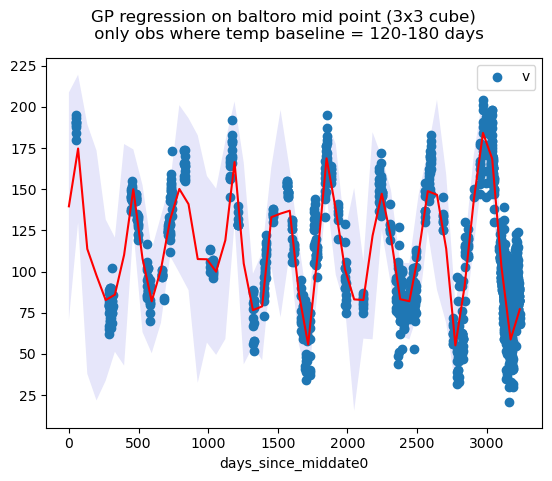

In [42]:
run_vis_GP_model(df1, 'GP regression on baltoro mid point (3x3 cube) \n only obs where temp baseline = 120-180 days', matern_kernel)

# obs in this group:  7565
0.693**2 * Matern(length_scale=10.2, nu=1.5) + WhiteKernel(noise_level=0.385)
log marginal likelihood:  -7609.358455501531
[-0.73338996  2.32094109 -0.95325603]
--
[[-11.51292546  11.51292546]
 [-13.81551056   5.29831737]
 [-13.81551056   6.90775528]]
--
get params: 
 {'k1': 0.693**2 * Matern(length_scale=10.2, nu=1.5), 'k2': WhiteKernel(noise_level=0.385), 'k1__k1': 0.693**2, 'k1__k2': Matern(length_scale=10.2, nu=1.5), 'k1__k1__constant_value': 0.48027810393060105, 'k1__k1__constant_value_bounds': (1e-05, 100000.0), 'k1__k2__length_scale': 10.185254991041784, 'k1__k2__length_scale_bounds': (1e-06, 200.0), 'k1__k2__nu': 1.5, 'k2__noise_level': 0.38548383245093976, 'k2__noise_level_bounds': (1e-06, 1000.0)}
--
0.693**2 * Matern(length_scale=10.2, nu=1.5)
WhiteKernel(noise_level=0.385)


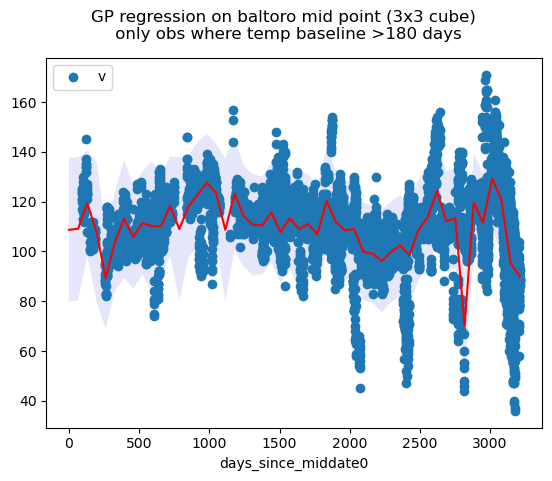

In [44]:
run_vis_GP_model(df2, 'GP regression on baltoro mid point (3x3 cube) \n only obs where temp baseline >180 days', matern_kernel)

<Axes: >

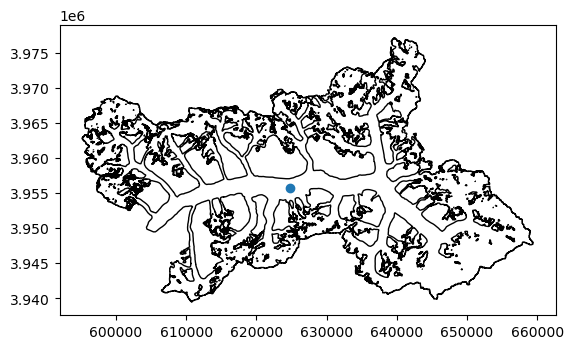

In [53]:
fig, ax = plt.subplots()
baltoro.outline.to_crs('EPSG:32643').plot(ax=ax, facecolor='None')
baltoro_mid_point.point_gdf.to_crs('EPSG:32643').plot(ax=ax)

In [51]:
baltoro.outline.to_crs('EPSG:32643')

<Projected CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["WGS_1 ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [59]:
df0

,mid_date,y,x,v,img_separation,step_count,mapping,days_since_middate0
20168,2013-05-18 05:30:10.536076032,3955627.5,624892.5,204.0,115.0,12218,0,40
20163,2013-05-18 05:30:10.536076032,3955747.5,624652.5,193.0,115.0,12218,0,40
20162,2013-05-18 05:30:10.536076032,3955867.5,624892.5,177.0,115.0,12218,0,40
20161,2013-05-18 05:30:10.536076032,3955867.5,624772.5,184.0,115.0,12218,0,40
20167,2013-05-18 05:30:10.536076032,3955627.5,624772.5,199.0,115.0,12218,0,40
...,...,...,...,...,...,...,...,...
14061,2022-02-21 05:49:02.535076096,3955747.5,624652.5,76.0,61.0,8475,0,3241
14062,2022-02-21 05:49:02.535076096,3955747.5,624772.5,107.0,61.0,8475,0,3241
14063,2022-02-21 05:49:02.535076096,3955747.5,624892.5,103.0,61.0,8475,0,3241
14064,2022-02-21 05:49:02.535076096,3955627.5,624652.5,112.0,61.0,8475,0,3241


In [74]:
df0['mid_date'].min
df0['mid_date'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 20168   2013-05-18 05:30:10.536076032
20163   2013-05-18 05:30:10.536076032
20162   2013-05-18 05:30:10.536076032
20161   2013-05-18 05:30:10.536076032
20167   2013-05-18 05:30:10.536076032
                     ...             
14061   2022-02-21 05:49:02.535076096
14062   2022-02-21 05:49:02.535076096
14063   2022-02-21 05:49:02.535076096
14064   2022-02-21 05:49:02.535076096
14066   2022-02-21 05:49:02.535076096
Name: mid_date, Length: 2247, dtype: datetime64[ns]>

In [129]:
x_test.squeeze()

array([   0.        ,   66.14285714,  132.28571429,  198.42857143,
        264.57142857,  330.71428571,  396.85714286,  463.        ,
        529.14285714,  595.28571429,  661.42857143,  727.57142857,
        793.71428571,  859.85714286,  926.        ,  992.14285714,
       1058.28571429, 1124.42857143, 1190.57142857, 1256.71428571,
       1322.85714286, 1389.        , 1455.14285714, 1521.28571429,
       1587.42857143, 1653.57142857, 1719.71428571, 1785.85714286,
       1852.        , 1918.14285714, 1984.28571429, 2050.42857143,
       2116.57142857, 2182.71428571, 2248.85714286, 2315.        ,
       2381.14285714, 2447.28571429, 2513.42857143, 2579.57142857,
       2645.71428571, 2711.85714286, 2778.        , 2844.14285714,
       2910.28571429, 2976.42857143, 3042.57142857, 3108.71428571,
       3174.85714286, 3241.        ])

In [134]:
x_test.shape

(50, 1)

In [105]:
import datetime
today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)

In [118]:
today

datetime.datetime(2023, 9, 27, 13, 22, 41, 180566)

In [111]:
current_month

2023.75

In [126]:
pd.timestamp(df0['mid_date'].iloc[0])

AttributeError: module 'pandas' has no attribute 'timestamp'

In [117]:
middate0 = .datetime.datetime.fromtimestamp(df0['mid_date'].iloc[0].date())

SyntaxError: invalid syntax (2081673890.py, line 1)